<a href="https://colab.research.google.com/github/pjcroxas/Remote-Sensing/blob/main/04_Process_Raster_Data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Lesson 2. Subtract One Raster from Another and Export a New GeoTIFF in Open Source Python
<hr>

Often you need to process two raster datasets together to create a new raster output and then save that output as a new file. In this lesson, you will learn how to subtract rasters and create a new GeoTIFF file in open source Python using rioxarray which is a wrapper package that adds additional spatial functions to xarray.



In [ ]:
# !pip install earthpy
# !pip install rioxarray

In [ ]:
import os
import matplotlib.pyplot as plt
import numpy as np
import geopandas as gpd
import seaborn as sns
import rioxarray as rxr
import earthpy as et

# Prettier plotting with seaborn
sns.set(font_scale=1.5,
        style="whitegrid")

# Get data and set wdir
et.data.get_data("colorado-flood")
os.chdir(os.path.join(et.io.HOME,
                      'earth-analytics',
                      'data'))

In [ ]:
# Define relative path of digital elevation model
lidar_dem_path = os.path.join("colorado-flood",
                              "spatial",
                              "boulder-leehill-rd",
                              "pre-flood",
                              "lidar",
                              "pre_DTM.tif")

# Open lidar dem
lidar_dem_xr = rxr.open_rasterio(lidar_dem_path,
                                 masked=True).squeeze()

lidar_dem_xr

<xarray.DataArray (y: 2000, x: 4000)>
[8000000 values with dtype=float32]
Coordinates:
    band         int64 1
  * x            (x) float64 4.72e+05 4.72e+05 4.72e+05 ... 4.76e+05 4.76e+05
  * y            (y) float64 4.436e+06 4.436e+06 ... 4.434e+06 4.434e+06
    spatial_ref  int64 0
Attributes:
    scale_factor:  1.0
    add_offset:    0.0

In [ ]:
# Define relative path of digital surface model
lidar_dsm_path = os.path.join("colorado-flood",
                              "spatial",
                              "boulder-leehill-rd",
                              "pre-flood",
                              "lidar",
                              "pre_DSM.tif")

# Open lidar dem
lidar_dsm_xr = rxr.open_rasterio(lidar_dsm_path,
                                 masked=True).squeeze()

lidar_dsm_xr

<xarray.DataArray (y: 2000, x: 4000)>
[8000000 values with dtype=float32]
Coordinates:
    band         int64 1
  * x            (x) float64 4.72e+05 4.72e+05 4.72e+05 ... 4.76e+05 4.76e+05
  * y            (y) float64 4.436e+06 4.436e+06 ... 4.434e+06 4.434e+06
    spatial_ref  int64 0
Attributes:
    scale_factor:  1.0
    add_offset:    0.0

In [ ]:
lidar_dsm_xr.shape

(2000, 4000)

### Canopy Height Model
<hr>
The canopy height model (CHM) represents the HEIGHT of the trees. This is not an elevation value, rather it’s the height or distance between the ground and the top of the trees (or buildings or whatever object that the lidar system detected and recorded).

Some canopy height models also include buildings, so you need to look closely at your data to make sure it was properly cleaned before assuming it represents all trees!

<b> Calculate difference between two rasters</b>
There are different ways to calculate a CHM. One easy way is to subtract the DEM from the DSM.

<b>DSM - DEM = CHM</b>

<small>Data Tip: Note that this method of subtracting 2 rasters to create a CHM may not give you the most accurate results! There are better ways to create CHM’s using the point clouds themselves. However, in this lesson you learn this method as a means to get more familiar with the CHM dataset and to understand how to perform raster calculations in `Python`.</small>

In [ ]:
# Are the bounds the same?
print("Is the spatial extent the same?",
      lidar_dem_xr.rio.bounds() == lidar_dsm_xr.rio.bounds())

# Is the resolution the same ??
print("Is the resolution the same?",
      lidar_dem_xr.rio.resolution() == lidar_dsm_xr.rio.resolution())

Is the spatial extent the same? True
Is the resolution the same? True


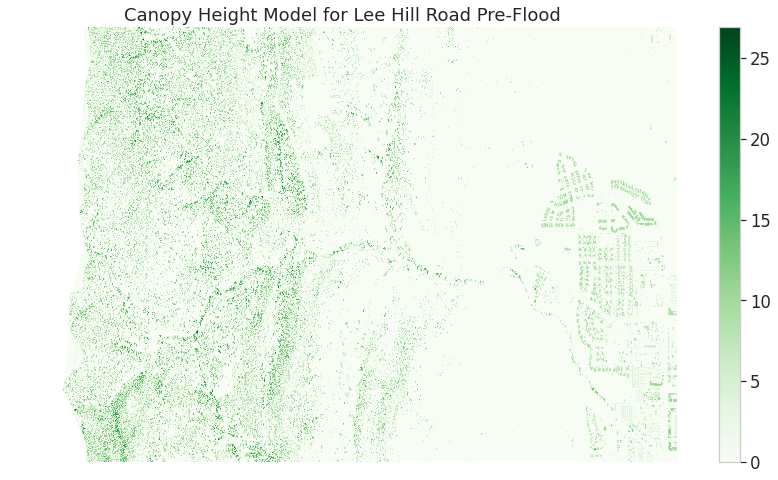

In [ ]:
# Calculate Canopy Height
lidar_chm_xr = lidar_dsm_xr - lidar_dem_xr

# Plot the data
f, ax = plt.subplots(figsize=(15,8))
lidar_chm_xr.plot(cmap="Greens")
ax.set(title="Canopy Height Model for Lee Hill Road Pre-Flood")
ax.set_axis_off()
plt.show()

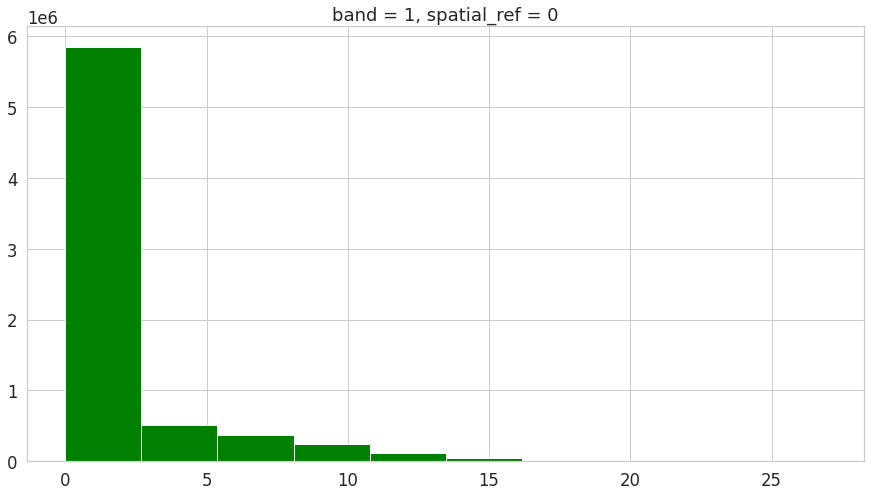

In [ ]:
# Plot histogram
lidar_chm_xr.plot.hist(color="green", figsize=(15,8))
plt.show()

Take a close look at the CHM plot. Do you think that the data just represents trees? Or do you see anything that may suggest that there are other types of objects represented in the data?

In [ ]:
# Do the data make sense

print('CHM minimum value: ', np.nanmin(lidar_chm_xr))
print('CHM max value: ', np.nanmax(lidar_chm_xr))

CHM minimum value:  0.0
CHM max value:  26.930054


### Export a Raster to Geotiff Using RioXarray
<hr>

You can export a raster file in python using the `rioxarray write()` function. Export the canopy height model that you just created to your data folder. You will create a new directory called “outputs” within the `colorado-flood` directory. This structure allows you to keep things organized, separating your outputs from the data you downloaded.



In [ ]:
data_path = os.path.join("colorado-flood",
                         "spatial",
                         "outputs")

if os.path.exists(data_path):
  print("The directory ", data_path, " exists!")
else:
  os.makedirs(data_path)

The directory  colorado-flood/spatial/outputs  exists!


In [ ]:
# Make sure that your output data has a crs & no data value defines
print("The crs is: ", lidar_chm_xr.rio.crs)
print("The no data value is: ", lidar_chm_xr.rio.nodata)

The crs is:  EPSG:32613
The no data value is:  None


In [ ]:
# create the path to a new file
pre_chm_data_path = os.path.join(data_path, "pre-flood-chm.tif")
pre_chm_data_path

'colorado-flood/spatial/outputs/pre-flood-chm.tif'

In [ ]:
# Export the data to geotiff format
lidar_chm_xr.rio.to_raster(pre_chm_data_path)

In [ ]:
# Reopen the Data
lidar_chm_data = rxr.open_rasterio(pre_chm_data_path,
                                   masked=True).squeeze()

lidar_chm_data

<xarray.DataArray (y: 2000, x: 4000)>
[8000000 values with dtype=float32]
Coordinates:
    band         int64 1
  * x            (x) float64 4.72e+05 4.72e+05 4.72e+05 ... 4.76e+05 4.76e+05
  * y            (y) float64 4.436e+06 4.436e+06 ... 4.434e+06 4.434e+06
    spatial_ref  int64 0
Attributes:
    scale_factor:  1.0
    add_offset:    0.0

### Lesson 3. Classify and Plot Raster Data in Python
<hr>

<b>Manually Reclassify Raster Data</b>

In this lesson, you will learn how to reclassify a raster dataset in Python. When you reclassify a raster, you create a new raster object / file that can be exported and shared with colleagues and / or open in other tools such as QGIS.

In that raster, each pixel is mapped to a new value based on some approach. This approach can vary depending upon your science question.

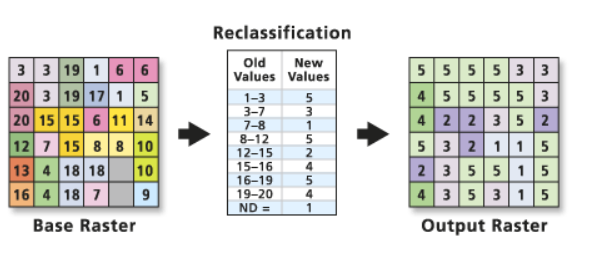

<small>When you reclassify a raster, you create a new raster. In that raster, each cell from the old raster is mapped to the new raster. The values in the new raster are applied using a defined range of values or a raster map. For example above you can see that all cells that contains the values 1-3 are assigned the new value of 5.</small>

Raster Classification Steps
<hr>

You can break your raster processing workflow into several steps as follows:

- <b>Data import / cleanup:</b> load and “clean” the data. This includes cropping, removing with nodata values
- <b>Data Exploration:</b> understand the range and distribution of values in your data. This may involve plotting histograms and scatter plots to determine what classes are appropriate for our data
- <b>Reclassify the Data:</b> Once you understand the distribution of your data, you are ready to reclassify. There are statistical and non-statistical approaches to reclassification. Here you will learn how to manually reclassify a raster using bins that you define in your data exploration step.

Please note - working with data is not a linear process. Above you see a potential workflow. You will develop your own workflow and approach.

To get started, first load the required libraries and then open up your raster. In this case, you are using the lidar canopy height model (CHM) that you calculated in the previous lesson.

In [ ]:
# !pip install rioxarray
# !pip install earthpy

In [ ]:
import os

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, BoundaryNorm
import numpy as np
import xarray as xr
import rioxarray as rxr
import earthpy as et
import earthpy.plot as ep
import geopandas as gpd

# Prettier plotting with seaborn
import seaborn as sns
sns.set(font_scale=1.5, style="whitegrid")

# Get data and set working directory
et.data.get_data("colorado-flood")
os.chdir(os.path.join(et.io.HOME,
                      'earth-analytics',
                      'data'))

In [ ]:
# Define relative paths to DTM and DSM files
dtm_path = os.path.join("colorado-flood",
                        "spatial",
                        "boulder-leehill-rd",
                        "pre-flood",
                        "lidar",
                        "pre_DTM.tif")

dsm_path = os.path.join("colorado-flood",
                        "spatial",
                        "boulder-leehill-rd",
                        "pre-flood",
                        "lidar",
                        "pre_DSM.tif")

# Open DTM and DSM file
pre_lidar_dtm = rxr.open_rasterio(dtm_path, masked=True).squeeze()
pre_lidar_dsm = rxr.open_rasterio(dsm_path, masked=True).squeeze()

# Create canopy height model
pre_lidar_chm = pre_lidar_dsm - pre_lidar_dtm
pre_lidar_chm

<xarray.DataArray (y: 2000, x: 4000)>
array([[       nan,        nan,        nan, ..., 0.        , 0.17004395,
        0.960083  ],
       [       nan,        nan,        nan, ..., 0.        , 0.09008789,
        1.6400146 ],
       [       nan,        nan,        nan, ..., 0.        , 0.        ,
        0.07995605],
       ...,
       [       nan,        nan,        nan, ..., 0.        , 0.        ,
        0.        ],
       [       nan,        nan,        nan, ..., 0.        , 0.        ,
        0.        ],
       [       nan,        nan,        nan, ..., 0.        , 0.        ,
        0.        ]], dtype=float32)
Coordinates:
    band         int64 1
  * x            (x) float64 4.72e+05 4.72e+05 4.72e+05 ... 4.76e+05 4.76e+05
  * y            (y) float64 4.436e+06 4.436e+06 ... 4.434e+06 4.434e+06
    spatial_ref  int64 0

<b>What Classification Values to Use?</b>
</hr>
There are many different approaches to classification. Some use highly sophisticated spatial algorithms that identify patterns in the data that can in turn be used to classify particular pixels into particular “classes”.

In this case, you are simply going to create the classes manually using the range of quantitative values found in our data.

Assuming that our data represent trees (though you know there are likely some buildings in the data), classify your raster into 3 classes:

- Short trees
- Medium trees
- Tall trees

To perform this classification, you need to understand which values represent short trees vs medium trees vs tall trees in your raster. This is where histograms can be extremely useful.

Start by looking at the min and max values in your CHM.

In [ ]:
# View min and max values in the data
print("CHM min values: ", np.nanmin(pre_lidar_chm))
print("CHM max values: ", np.nanmax(pre_lidar_chm))

CHM min values:  0.0
CHM max values:  26.930054


<b>Get to Know Raster Summary Statistics</b>

Get to know your data by looking at a histogram. A histogram quantifies the distribution of values found in your data.

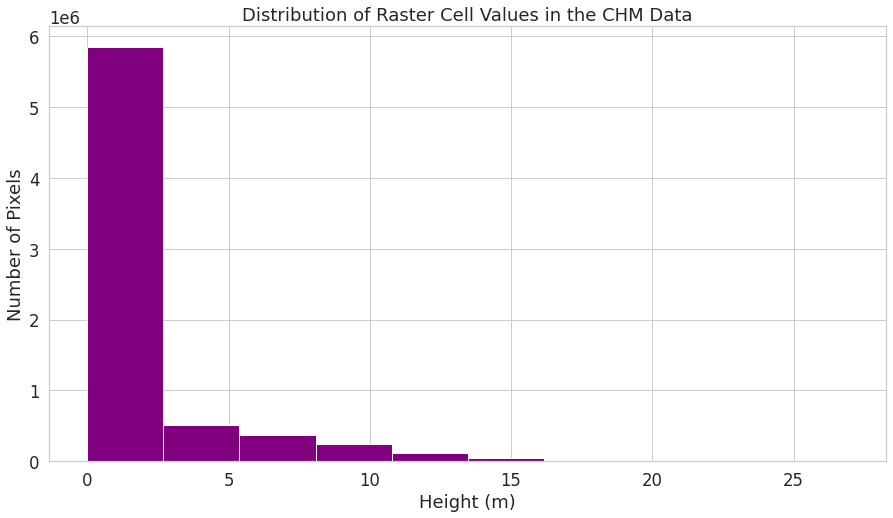

In [ ]:
f, ax = plt.subplots( figsize=(15,8))
pre_lidar_chm.plot.hist(color="purple", ax=ax)
ax.set(title="Distribution of Raster Cell Values in the CHM Data",
       xlabel="Height (m)",
       ylabel="Number of Pixels")

plt.show()

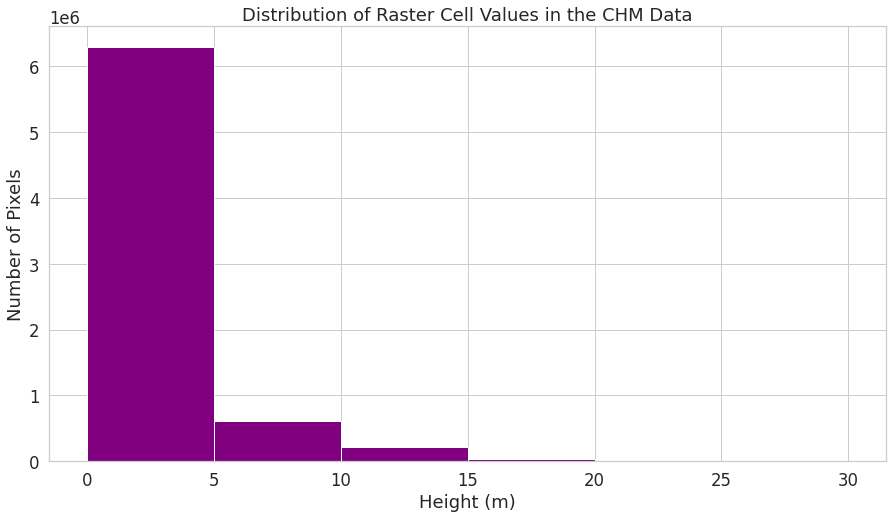

In [ ]:
# Histogram with custom breaks
f, ax = plt.subplots( figsize=(15,8))
pre_lidar_chm.plot.hist(color="purple", ax=ax, bins=[0, 5, 10, 15, 20, 30])
ax.set(title="Distribution of Raster Cell Values in the CHM Data",
       xlabel="Height (m)",
       ylabel="Number of Pixels")

plt.show()

You may want to play with the distribution of breaks. Below it appears as if there are many values close to 0.

In the case of this lidar instrument, you know that values between 0 and 2 meters are not reliable (you know this if you read the documentation about the NEON sensor and how these data were processed).

Below you create a bin between 0-2.

You also know you want to create bins for short, medium and tall trees, so experiment with those bins as well.

Below following breaks are used:
- 0 - 2 = no trees
- 2 - 7 = short trees
- 7 - 12 = medium trees
- `>` 12 = tall trees

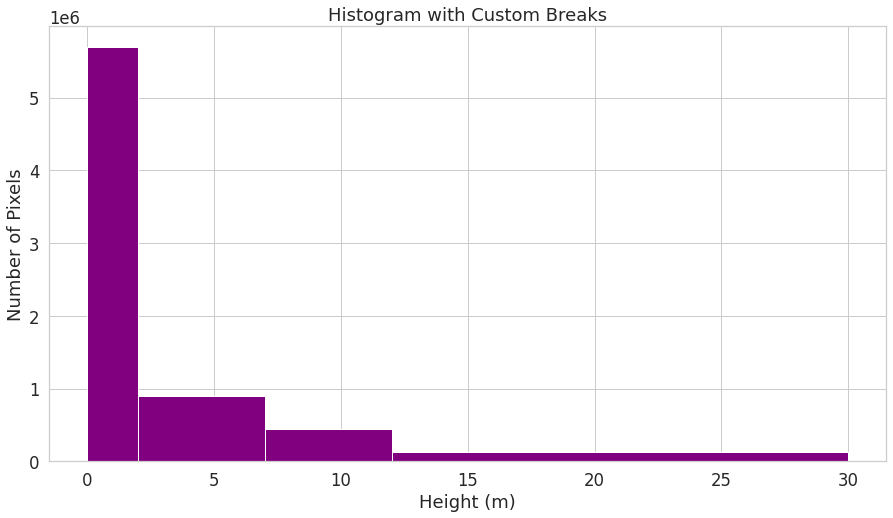

In [ ]:
# Histogram with custom breaks
f, ax = plt.subplots(figsize=(15,8))

pre_lidar_chm.plot.hist(
    color='purple',
    bins=[0, 2, 7, 12, 30])
ax.set(title="Histogram with Custom Breaks",
       xlabel="Height (m)",
       ylabel="Number of Pixels")

plt.show()

<b> Map Raster Values to New Values</b>

To reclassify your raster, first you need to create a reclassification matrix.

This matrix MAPS a range of values to a new defined value. You will use this matrix to create a classified canopy height model where you designate short, medium and tall trees.

The newly defined values will be as follows:

- No trees: (0m - 2m tall) = NA
- Short trees: (2m - 7m tall) = 1
- Medium trees: (7m - 12m tall) = 2
- Tall trees: (> 12m tall) = 3

Notice in the list above that you set cells with a value between 0 and 2 meters to NA or `nodata` value. This means you are assuming that there are no trees in those locations!

Notice in the matrix below that you use Inf to represent the largest or max value found in the raster. So our assignment is as follows:

- 0 - 2 meters -> 1
- 2 - 7 meters -> 2 (short trees)
- 7 - 12 meters -> 3 (medium trees)
- `>` 12 or 12 - Inf -> 4 (tall trees)

In [ ]:
data_min_value = np.nanmin(pre_lidar_chm)
data_max_value = np.nanmax(pre_lidar_chm)
print(data_min_value, data_max_value)

0.0 26.930054


In [ ]:
class_bins = [-np.inf, 2, 7, 12, np.inf]
class_bins

[-inf, 2, 7, 12, inf]

In [ ]:
pre_lidar_chm_class = xr.apply_ufunc(np.digitize,
                                     pre_lidar_chm,
                                     class_bins)

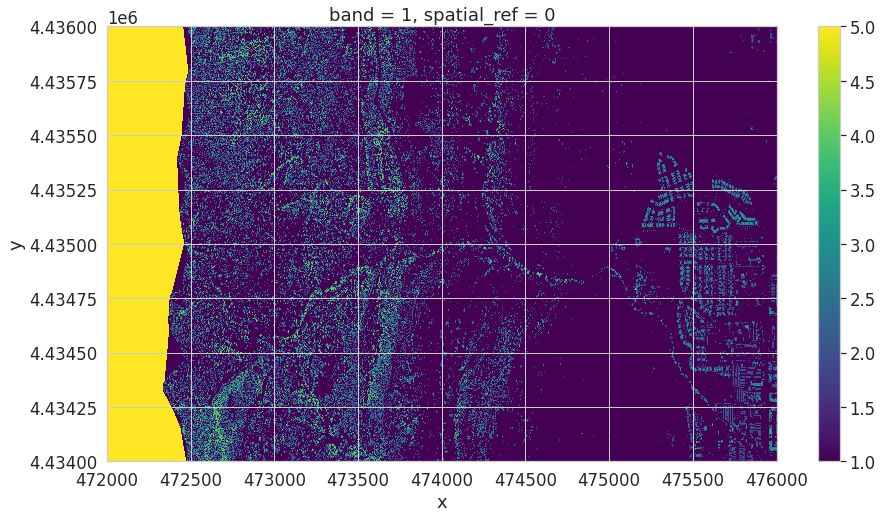

In [ ]:
# Values of 5 represent missing data

# f, ax = plt.subplots(figsize=(15,8))
im = pre_lidar_chm_class.plot.imshow(figsize=(15,8))
ax.set_axis_off()

<small>Raster plot of your classified CHM. Notice the yellow on the left side of the plot. Those pixels do not contain data and have been automatically classified as value = 5. You can mask those pixels for a nicer final plot.</small>

After running the classification, you have one extra class. This class - the first class - is your missing data value. Your classified array output is also a regular (not a masked) array.

You can reassign the first class in your data to a mask using `xarray .where()`.

In [ ]:
# Mask out values not equal to 5
pre_lidar_chm_class_ma = pre_lidar_chm_class.where(pre_lidar_chm_class !=5)
pre_lidar_chm_class_ma

<xarray.DataArray (y: 2000, x: 4000)>
array([[nan, nan, nan, ...,  1.,  1.,  1.],
       [nan, nan, nan, ...,  1.,  1.,  1.],
       [nan, nan, nan, ...,  1.,  1.,  1.],
       ...,
       [nan, nan, nan, ...,  1.,  1.,  1.],
       [nan, nan, nan, ...,  1.,  1.,  1.],
       [nan, nan, nan, ...,  1.,  1.,  1.]])
Coordinates:
    band         int64 1
  * x            (x) float64 4.72e+05 4.72e+05 4.72e+05 ... 4.76e+05 4.76e+05
  * y            (y) float64 4.436e+06 4.436e+06 ... 4.434e+06 4.434e+06
    spatial_ref  int64 0

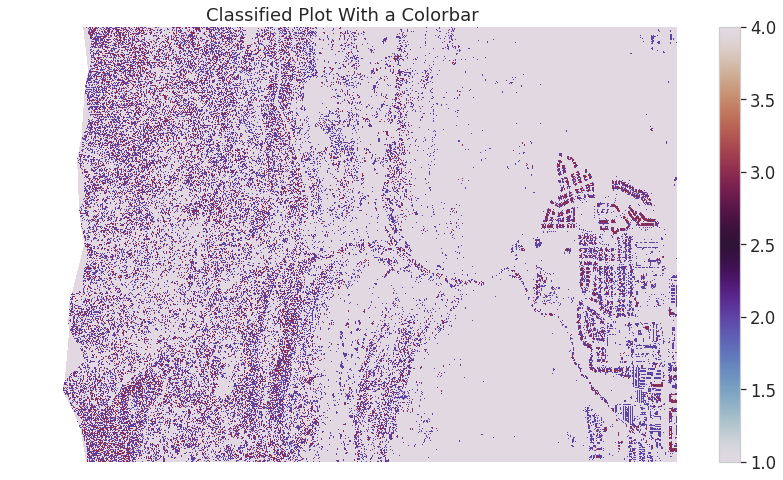

In [ ]:
# Plot newly classified and masked raster
f, ax = plt.subplots(figsize=(15,8))
pre_lidar_chm_class_ma.plot.imshow(cmap="twilight")
ax.set(title="Classified Plot With a Colorbar")

ax.set_axis_off()
plt.show()

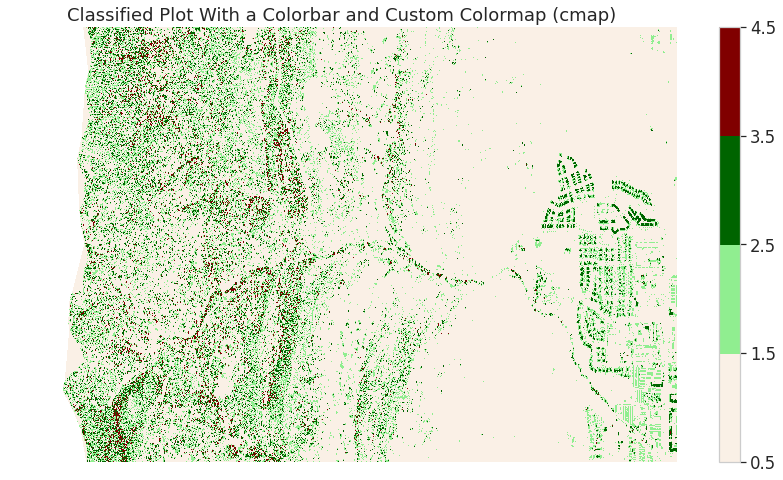

In [ ]:
# Plot data using nicer colors
colors = ['linen', 'lightgreen', 'darkgreen', 'maroon']
class_bins = [.5, 1.5, 2.5, 3.5, 4.5]
cmap = ListedColormap(colors)
norm = BoundaryNorm(class_bins,
                    len(colors))

# Plot newly classified and masked raster
f, ax = plt.subplots(figsize=(15, 8))
pre_lidar_chm_class_ma.plot.imshow(cmap=cmap,
                                   norm=norm)
ax.set(title="Classified Plot With a Colorbar and Custom Colormap (cmap)")
ax.set_axis_off()
plt.show()


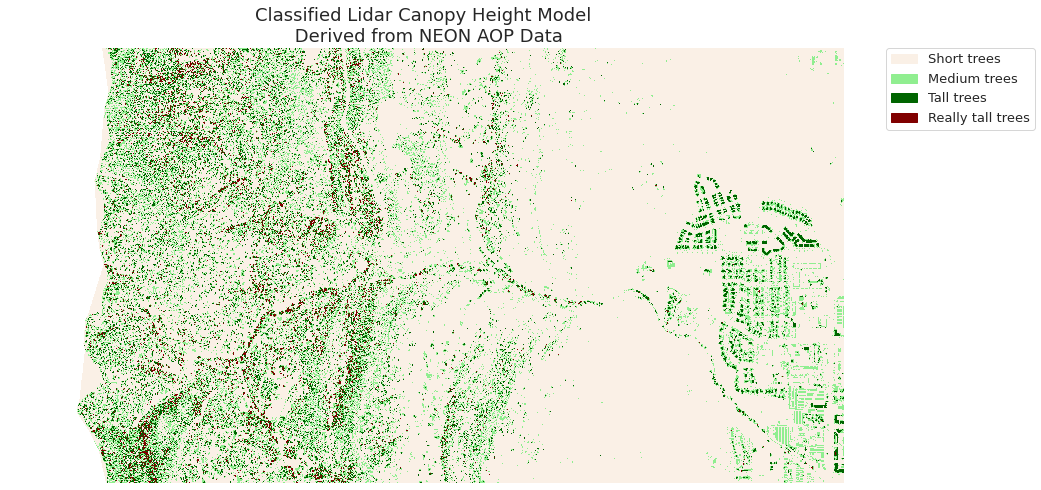

In [ ]:
# Create a list of labels to use for your legend
height_class_labels = ["Short trees",
                       "Medium trees",
                       "Tall trees",
                       "Really tall trees"]

# Create a colormap from a list of colors
colors = ['linen',
          'lightgreen',
          'darkgreen',
          'maroon']

cmap = ListedColormap(colors)

class_bins = [.5, 1.5, 2.5, 3.5, 4.5]
norm = BoundaryNorm(class_bins,
                    len(colors))

# Plot newly classified and masked raster
f, ax = plt.subplots(figsize=(15, 8))
im = pre_lidar_chm_class_ma.plot.imshow(cmap=cmap,
                                        norm=norm,
                                        # Turn off colorbar
                                        add_colorbar=False)
# Add legend using earthpy
ep.draw_legend(im,
               titles=height_class_labels)
ax.set(title="Classified Lidar Canopy Height Model \n Derived from NEON AOP Data")
ax.set_axis_off()
plt.show()

### Lesson 4. Crop Spatial Raster Data With a Shapefile in Python
<hr>

Cropping (sometimes also referred to as clipping), is when you subset or make a dataset smaller, by removing all data outside of the crop area or spatial extent. In this case you have a large raster - but let’s pretend that you only need to work with a smaller subset of the raster.

You can use the `crop_image` function to remove all of the data outside of your study area. This is useful as it:

1. Makes the data smaller and
2. Makes processing and plotting faster


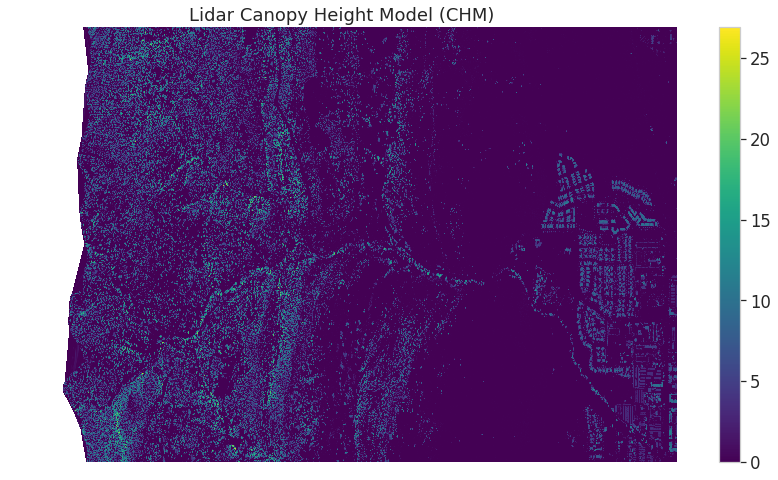

In [ ]:
lidar_chm_path = os.path.join("colorado-flood",
                              "spatial"
                              "boulder-leehill-rd",
                              "outputs",
                              "lidar_chm.tif")

lidar_chm_im = rxr.open_rasterio("colorado-flood/spatial/boulder-leehill-rd/outputs/lidar_chm.tif",
                                 masked=True).squeeze()

f, ax = plt.subplots(figsize=(15, 8))
lidar_chm_im.plot.imshow()
ax.set(title="Lidar Canopy Height Model (CHM)")

ax.set_axis_off()
plt.show()

**Open Vector Layer**
<hr>
To begin your clip, open up a vector layer that contains the crop extent that you want to use to crop your data. To open a shapefile you use the `gpd.read_file()` function from geopandas. You will learn more about vector data in Python in a few weeks.




In [ ]:
aoi = os.path.join("colorado-flood",
                   "spatial",
                   "boulder-leehill-rd",
                   "clip-extent.shp")

crop_extent = gpd.read_file(aoi)

In [ ]:
# View the crs
print("Crop extent CRS: ", crop_extent.crs)
print("LIDAR CRS: ", lidar_chm_im.rio.crs)

Crop extent CRS:  epsg:32613
LIDAR CRS:  EPSG:32613


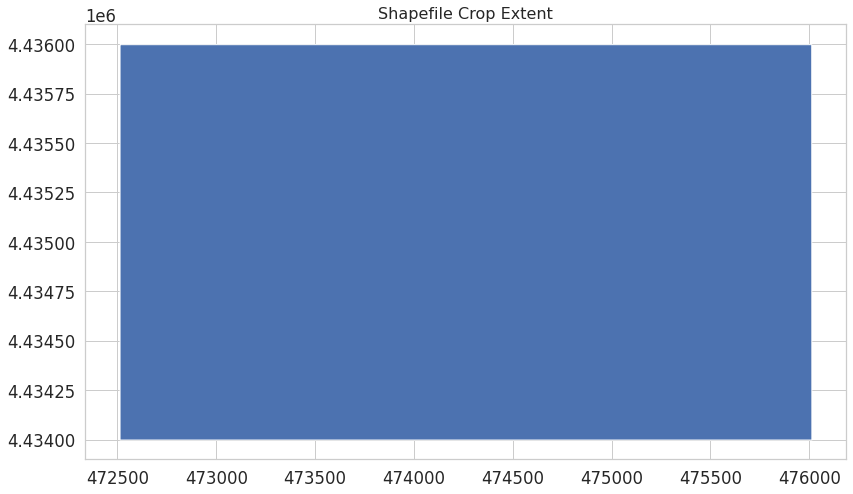

In [ ]:
# Plot the boundary
fig, ax = plt.subplots(figsize=(15,8))
crop_extent.plot(ax=ax)
ax.set_title("Shapefile Crop Extent",
             fontsize=16)
plt.show()

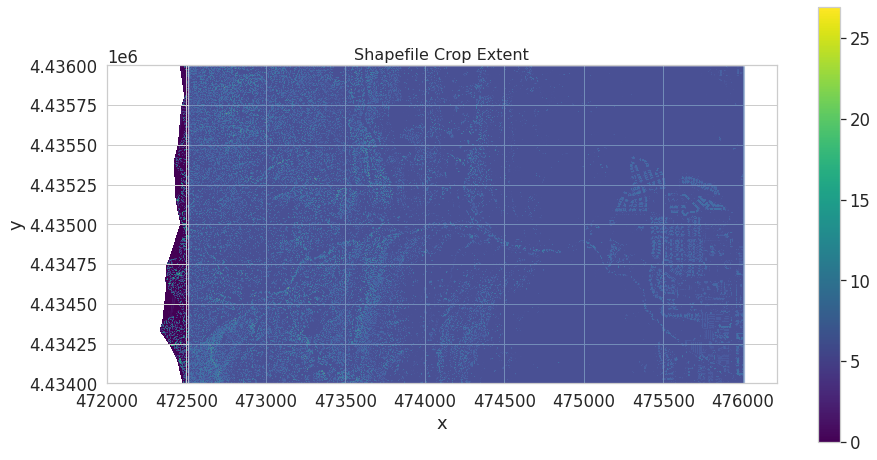

In [ ]:
# Plot the boundary with the raster file
fig, ax = plt.subplots(figsize=(15,8))
lidar_chm_im.plot.imshow(ax=ax)
crop_extent.plot(ax=ax,
                 alpha=0.7)
ax.set_title("Shapefile Crop Extent",
             fontsize=16)
plt.show()

**Clip Raster Data Using RioXarray .clip**

If you want to crop the data you can use the rio.clip function. When you clip the data, you can then export it and share it with colleagues. Or use it in another analysis.

To perform the clip you:

1. Open the raster dataset that you wish to crop using xarray or rioxarray.

2. Open your shapefile as a geopandas object.

3. Crop the data using the `.clip()` function.

`.clip` has several parameters that you can consider including

- `drop = True` : The default. setting it will drop all pixels outside of the clip extent

- `invert = False` : The default. If set to true it will clip all data INSIDE of the clip extent

- `crs` : if your shapefile is in a different CRS than the raster data, pass the CRS to ensure the data are clipped correctly.

Below you clip the data to the extent of the AOI geodataframe imported above. The data are then plotted.

In [ ]:
from shapely.geometry import mapping

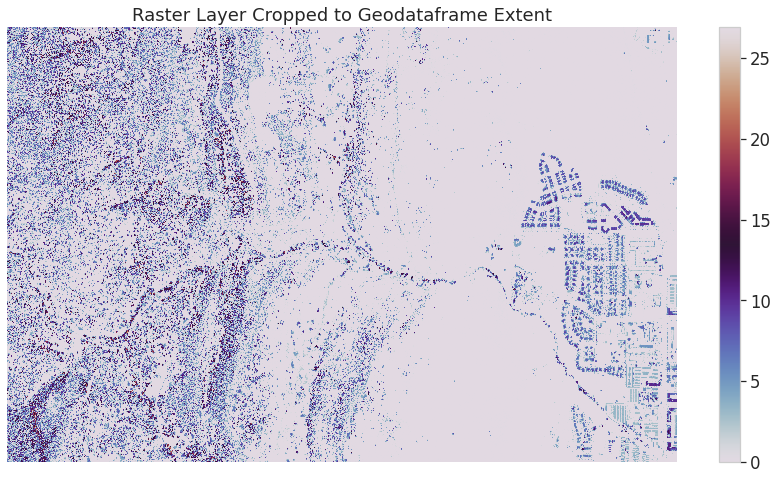

In [ ]:
lidar_clipped = lidar_chm_im.rio.clip(crop_extent.geometry.apply(mapping), # This is needed if your GDF is in a diff CRS than the raster data
                                      crop_extent.crs)
f, ax = plt.subplots(figsize=(15,8))

lidar_clipped.plot(ax=ax, cmap="twilight")
ax.set(title="Raster Layer Cropped to Geodataframe Extent")
ax.set_axis_off()
plt.show()

### Lesson 5. Reproject Raster Data Python
<hr>
**Reprojecting**
Sometimes you your raster data are not all in the same Coordinate Reference Systems (CRS). When this happens, you may need to reproject your data from it’s current CRS to match the CRS of other data that you are using.

**Data Tip**

Proceed with caution when you are reprojecting raster data. Often it’s best to reproject your vector data as reprojecting a raster means that the entire dataset are interpolated and cast into a new grid system. This adds error and uncertainty to your analysis. There are times when you need to reproject your data. However, consider carefully whether you need to do this, before implementimg it in an analysis.

In [ ]:
import os

import matplotlib.pyplot as plt
import numpy as np
import geopandas as gpd
from rasterio.crs import CRS
import rioxarray as rxr
import earthpy as et

# Get data and set working directory
et.data.get_data("colorado-flood")
os.chdir(os.path.join(et.io.HOME,
                      'earth-analytics',
                      'data'))

/usr/local/lib/python3.7/dist-packages/geopandas/_compat.py:115: UserWarning: The Shapely GEOS version (3.10.2-CAPI-1.16.0) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  shapely_geos_version, geos_capi_version_string


In this lesson, you have a few different layers that are in different coordinate reference systems

1. Boulder County Roads: You have a shapefile representing roads in Boulder County, Colorado

2. You have a AOI extent that represents your study area in Boulder, Colorado

3. You have a raster layer for that study area.

Typically, when it is possible, you want to avoid reprojecting raster data. It’s often easier and carries less error when you reproject the vector layers. However, in this lesson the goal is to learn how to reproject raster data. As such, for this lesson you will reproject a raster layer to align with the CRS of your vector data.

To begin, open up the road centerline data for Boulder, Colorado. Take note of the CRS of the road centerlines vector data.

In [ ]:
# Get data from Boulder Open Data portal
boulder_roads = gpd.read_file(
    "https://opendata.arcgis.com/datasets/5388d74deeb8450e8b0a45a542488ec8_0.geojson")

boulder_roads.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [ ]:
# Clip the boulder data to the extent of the study area aoo
aoi_path = os.path.join("colorado-flood",
                        "spatial",
                        "boulder-leehill-rd",
                        "clip-extent.shp")

# Open crop extent
crop_extent = gpd.read_file(aoi_path)

# Reproject the crop extent data to match the road layer
crop_extent_wgs84 = crop_extent.to_crs(boulder_roads.crs)

# Clip the buildings and roads to the extent of the study area using geopandas
roads_clip = gpd.clip(boulder_roads,
                      crop_extent_wgs84)

**In case you encounter this error**

ImportError: Spatial indexes require either `rtree` or `pygeos`. See installation instructions at https://geopandas.org/install.html

Run this installation scripts and restart the runtime.

1. `!apt install libspatialindex-dev`
2. `!pip3 install rtree`


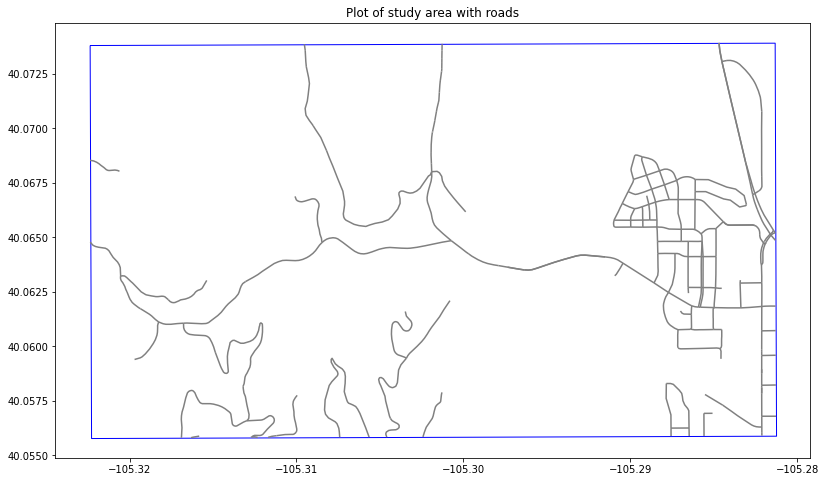

In [ ]:
# Plot the clipped data
f, ax = plt.subplots(figsize=(15,8))

crop_extent_wgs84.plot(ax=ax,
                       edgecolor="blue",
                       color="white")

roads_clip.plot(ax=ax,
                color="grey")
ax.set(title="Plot of study area with roads")
plt.show()

Next, you will open up the digital terrain model for your study area. Note the CRS of your raster data which is UTM zone 13 epgs 32613.

In [ ]:
# Open up a DTM
lidar_dem_path = os.path.join("colorado-flood",
                              "spatial",
                              "boulder-leehill-rd",
                              "pre-flood",
                              "lidar",
                              "pre_DTM.tif")

lidar_dem = rxr.open_rasterio(lidar_dem_path,
                              masked=True).squeeze()
# CHeck the CRS
lidar_dem.rio.crs

CRS.from_epsg(32613)

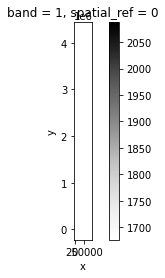

In [ ]:
# When you try to overlay the building footprints the data don't line up
f, ax = plt.subplots()
lidar_dem.plot.imshow(ax=ax,
                      cmap='Greys')
roads_clip.plot(ax=ax)

plt.show()

<small>Plot showing what happens when the data are not in the same CRS. The data do not plot properly.

**Reproject Your Raster Data Using RioXarray**
<hr>

You can reproject your data using the crs of the roads data using rioxarray. Below, you reproject your data using:

You can provide the crs by

1. grabbing the CRS of another spatial layer
2. as an Proj4 string

Below you use the crs value for the Geopandas layer that you opened above.

In [ ]:
# Reproject the data using the crs from the roads layer
lidar_dem_wgs84 = lidar_dem.rio.reproject(roads_clip.crs)
lidar_dem_wgs84.rio.crs

CRS.from_epsg(4326)

In [ ]:
# Reproject the data to another crs - 4326
# Create a rasterio crs object for wgs 84 crs - lat /lon
crs_wgs84 = CRS.from_string('EPSG:4326')

# Reproject the data using the crs object
lidar_dem_wgs84_2 = lidar_dem.rio.reproject(crs_wgs84)
lidar_dem_wgs84_2.rio.crs

CRS.from_epsg(4326)

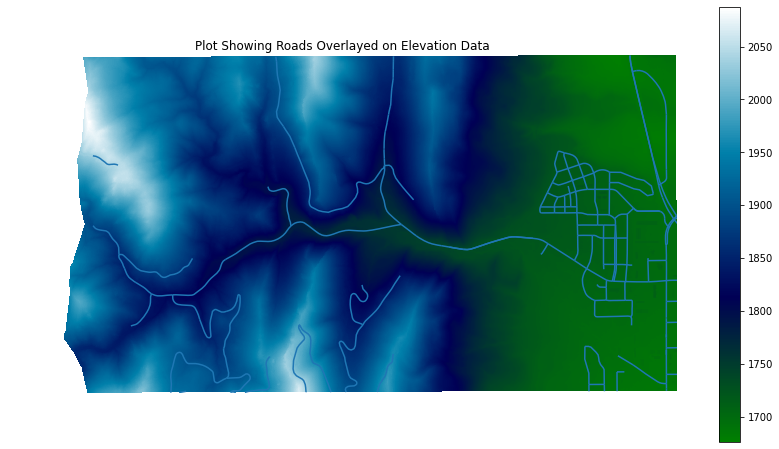

In [ ]:
# Plot your newly converted data
f, ax = plt.subplots(figsize=(15, 8))

lidar_dem_wgs84.plot.imshow(ax=ax,
                            cmap='ocean')
roads_clip.plot(ax=ax)
ax.set(title="Plot Showing Roads Overlayed on Elevation Data")
ax.set_axis_off()
plt.show()

Challenge: Reproject the hillside

In [ ]:
# Open up a hillshade
lidar_dem_path_hill = os.path.join("colorado-flood",
                                   "spatial",
                                   "boulder-leehill-rd",
                                   "pre-flood",
                                   "lidar",
                                   "pre_DTM_hill.tif")

lidar_dem_hill = rxr.open_rasterio(lidar_dem_path_hill,
                                   masked=True).squeeze()
# CHeck the CRS
lidar_dem_hill.rio.crs

CRS.from_epsg(32613)

In [ ]:
# Reproject the hill data using the crs from the roads layer
lidar_dem_hill = lidar_dem_hill.rio.reproject(roads_clip.crs)
lidar_dem_hill.rio.crs

CRS.from_epsg(4326)

In [ ]:
# Reproject the data to another crs - 4326
# Create a rasterio crs object for wgs 84 crs - lat /lon
crs_wgs84 = CRS.from_string('EPSG:4326')

# Reproject the data using the crs object
lidar_dem_hill_wgs84_2 = lidar_dem_hill.rio.reproject(crs_wgs84)
lidar_dem_hill_wgs84_2.rio.crs

CRS.from_epsg(4326)

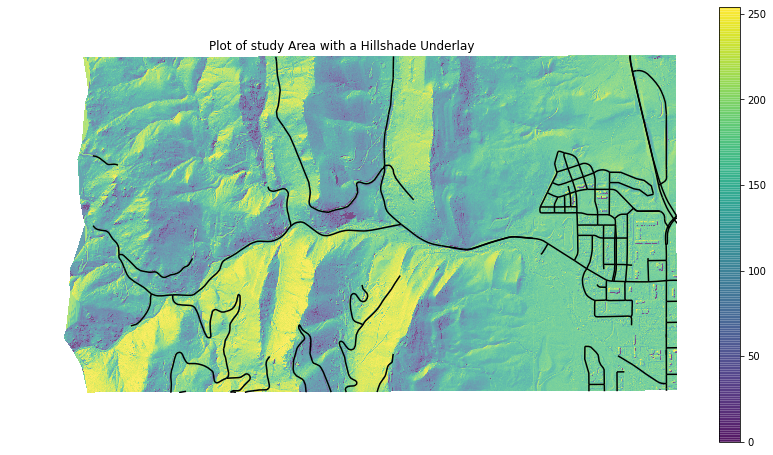

In [ ]:
# Plot your newly converted data
f, ax = plt.subplots(figsize=(15, 8))
lidar_dem_hill.plot.imshow(ax=ax,
                            cmap='viridis', alpha=0.7)
roads_clip.plot(ax=ax, color='black')
ax.set(title="Plot of study Area with a Hillshade Underlay")
ax.set_axis_off()
plt.show()